In [1]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
import numpy as np
from pathlib import Path

# ================================
# Process the FF10_POINT file for InMAP compatibility
# ================================

# Path to your specific FF10_POINT format file
file_path = "../data/raw/point/2022hc_cb6_22m/inputs/ptegu/egu_cems_2022_POINT_20240615_2022cems_stackfix2_23jul2024_v0.csv"

print(f"Reading data from {file_path}...")

# Create output directory if it doesn't exist
output_dir = Path("../data/processed")
output_dir.mkdir(parents=True, exist_ok=True)

# Count number of header lines to skip
with open(file_path, 'r') as f:
    header_lines = 0
    for line in f:
        if line.startswith('#'):
            header_lines += 1
        else:
            break

# Read the FF10_POINT file, skipping header comments
df = pd.read_csv(file_path, skiprows=header_lines, low_memory=False)

print(f"Data loaded. Shape: {df.shape}")

# Initialize lists to hold the processed data
VOC, NOx, NH3, SOx, PM2_5, CO2 = [], [], [], [], [], []
height, diam, temp, velocity = [], [], [], []
coords = []
naics_codes = []  # Track NAICS codes for each emission point

# Define pollutant classifications based on the provided list
voc_pollutants = [
    'VOC', 
    # Volatile organic compounds
    '75092', '71432', '50000', '110543', '85018', '91203', '108883',
    '86737', '91576', '206440', '129000', '107028', '75070', '75569',
    '1330207', '106990', '100414', '108952', '106467', '60344', '67663',
    '78591', '80626', '74839', '74873', '75003', '75150', '75252',
    '77781', '92524', '98828', '98862', '100425', '100447', '106934',
    '107062', '108054', '108907', '117817', '121142', '123386', '127184',
    '1634044', '107131', '74884', '92875', '108101', '131113', '132649',
    '56235', '71556', '75014', '78875', '87865', '95476', '75354', '79005',
    '84742', '85449', '91225', '106423', '106445', '95487', '108383',
    '108394', '75343', '120821', '88062', '91587', '57147', '107051',
    '67561', '86748', '59892', '1319773', '189640', '91941', '77474',
    '95807', 'HOURACT', '79016', '542756', '118741', '1336363', '192972'
]

nox_pollutants = [
    'NOX', 'NO3', 'N590'
]

sox_pollutants = [
    'SO2', 'SO4', '7783064'
]

nh3_pollutants = [
    'NH3'
]

pm25_pollutants = [
    'PM25-PRI', 'PM25-FIL', 'PMFINE', 'PM-CON', 'EC', 'OC'
]

co2_pollutants = [
    'CO2'
]

# Create dictionaries to store emissions by location
location_data = {}

# Process each row of the FF10_POINT file
for _, row in df.iterrows():
    try:
        # Get pollutant code and value
        poll = str(row['poll']).upper() if 'poll' in row else ""
        emis_value = row['ann_value'] if 'ann_value' in row else 0
        
        # Skip if no emissions value
        if pd.isna(emis_value) or emis_value == '':
            continue
            
        # Convert emissions value to float
        emis_value = float(emis_value)
        
        # Get units and convert to short tons if needed
        emis_units = row['emissions uom'] if 'emissions uom' in row else 'TON'
        if emis_units == 'LB':
            emis_value = emis_value / 2000  # Convert pounds to short tons
        
        # Get coordinates
        lon = row['longitude'] if 'longitude' in row else None
        lat = row['latitude'] if 'latitude' in row else None
        
        if lon is None or lat is None or pd.isna(lon) or pd.isna(lat):
            continue  # Skip records without valid coordinates
        
        # Create a location key for aggregating emissions
        loc_key = (float(lon), float(lat))
        
        # Get stack parameters
        h = row['stkhgt'] if 'stkhgt' in row else ''
        if h != '' and not pd.isna(h):
            # Convert feet to meters
            h_val = float(h) * 0.3048
        else:
            h_val = 0
            
        d = row['stkdiam'] if 'stkdiam' in row else ''
        if d != '' and not pd.isna(d):
            # Convert feet to meters
            d_val = float(d) * 0.3048
        else:
            d_val = 0
            
        t = row['stktemp'] if 'stktemp' in row else ''
        if t != '' and not pd.isna(t):
            # Convert F to K
            t_val = (float(t) - 32) * 5.0/9.0 + 273.15
        else:
            t_val = 0
            
        v = row['stkvel'] if 'stkvel' in row else ''
        if v != '' and not pd.isna(v):
            # Convert ft/s to m/s
            v_val = float(v) * 0.3048
        else:
            v_val = 0
        
        # Get NAICS code
        naics = row['naics'] if 'naics' in row else None
        naics_str = str(naics) if naics is not None and not pd.isna(naics) else ''
        
        # If this is the first emission value for this location, initialize
        if loc_key not in location_data:
            location_data[loc_key] = {
                'VOC': 0, 'NOx': 0, 'NH3': 0, 'SOx': 0, 'PM2_5': 0, 'CO2': 0,
                'height': h_val, 'diam': d_val, 'temp': t_val, 'velocity': v_val,
                'naics': naics_str
            }
        
        # Categorize and add pollutant
        if poll in voc_pollutants:
            location_data[loc_key]['VOC'] += emis_value
        elif poll in nox_pollutants:
            location_data[loc_key]['NOx'] += emis_value
        elif poll in nh3_pollutants:
            location_data[loc_key]['NH3'] += emis_value
        elif poll in sox_pollutants:
            location_data[loc_key]['SOx'] += emis_value
        elif poll in pm25_pollutants:
            location_data[loc_key]['PM2_5'] += emis_value
        elif poll in co2_pollutants:
            location_data[loc_key]['CO2'] += emis_value
            
    except Exception as e:
        print(f"Error processing row: {e}")
        continue

# Convert the aggregated location data into lists for the GeoDataFrame
for loc, data in location_data.items():
    coords.append(Point(loc[0], loc[1]))
    VOC.append(data['VOC'])
    NOx.append(data['NOx'])
    NH3.append(data['NH3'])
    SOx.append(data['SOx'])
    PM2_5.append(data['PM2_5'])
    CO2.append(data['CO2'])
    height.append(data['height'])
    diam.append(data['diam'])
    temp.append(data['temp'])
    velocity.append(data['velocity'])
    naics_codes.append(data['naics'])

print(f"Processed {len(coords)} unique emission locations")

# Create the emissions GeoDataFrame
data_dict = {
    "VOC": VOC, 
    "NOx": NOx, 
    "NH3": NH3, 
    "SOx": SOx, 
    "PM2_5": PM2_5,
    "CO2": CO2,
    "height": height, 
    "diam": diam, 
    "temp": temp, 
    "velocity": velocity,
    "naics_code": naics_codes
}

emis = gpd.GeoDataFrame(data_dict, geometry=coords, crs='epsg:4269')

# Filter out any rows with all zeros for InMAP-relevant emissions
emis = emis[(emis['VOC'] > 0) | (emis['NOx'] > 0) | (emis['NH3'] > 0) | 
            (emis['SOx'] > 0) | (emis['PM2_5'] > 0)]

print(f"Filtered to {len(emis)} emission points with non-zero emissions")

# ================================
# Filter for power plants
# ================================

# This is already EGU CEMS data, so all should be power plants
# But check NAICS codes if available for validation
egu_naics_prefixes = ['2211', '221111', '221112', '221113', '221114', '221115', 
                      '221116', '221117', '221118', '221121', '221122']

# Create a mask for power plants
is_power_plant = emis['naics_code'].apply(
    lambda x: any(str(x).startswith(prefix) for prefix in egu_naics_prefixes) 
              if x else False
)

# Apply the mask to filter for power plants if NAICS codes are available and identified
if is_power_plant.any():
    egu_emis = emis[is_power_plant].copy()
    print(f"Filtered to {len(egu_emis)} power plant emission points using NAICS codes")
else:
    # Since this is EGU CEMS data, we can use all points even without NAICS codes
    print("Using all emission points (dataset is already for power plants - EGU CEMS)")
    egu_emis = emis.copy()

# ================================
# Inspect and validate the emissions data
# ================================

# Display summary statistics - properly handle the geometry column
print("\nEmissions Summary (in short tons/year):")
# Convert to DataFrame to exclude geometry column for sum operation
emissions_df = pd.DataFrame(egu_emis.drop(columns=['geometry']))
emission_sums = emissions_df[["VOC", "NOx", "NH3", "SOx", "PM2_5", "CO2"]].sum()
print(emission_sums)

print("\nStack Parameter Statistics:")
stack_stats = emissions_df[["height", "diam", "temp", "velocity"]].describe()
print(stack_stats)

# ================================
# Prepare Final Output for InMAP
# ================================

# Create a copy with just the InMAP required columns
inmap_columns = ["VOC", "NOx", "NH3", "SOx", "PM2_5", "height", "diam", "temp", "velocity", "geometry"]
inmap_egu = egu_emis[inmap_columns].copy()

# Save both versions - one with CO2 for climate modeling, one for InMAP
full_output_file = f"{output_dir}/processed_emissions_with_co2.gpkg"
egu_emis.to_file(full_output_file, driver="GPKG")
print(f"\nSaved complete emissions data (with CO2) to {full_output_file}")

inmap_output_file = f"{output_dir}/processed_emissions_for_inmap.gpkg"
inmap_egu.to_file(inmap_output_file, driver="GPKG")
print(f"Saved InMAP-formatted emissions data to {inmap_output_file}")

print("\nReady to use with run_sr function!")
print("Example: resultsISRM = run_sr(inmap_egu, model='isrm', emis_units='tons/year')")

# The emissions GeoDataFrame is now in the exact format needed for InMAP
egu_gdf = inmap_egu  # For use with run_sr
egu_with_co2 = egu_emis  # For use with climate damage calculations

Reading data from ../data/raw/point/2022hc_cb6_22m/inputs/ptegu/egu_cems_2022_POINT_20240615_2022cems_stackfix2_23jul2024_v0.csv...
Data loaded. Shape: (126465, 77)
Processed 2080 unique emission locations
Filtered to 2077 emission points with non-zero emissions
Filtered to 2031 power plant emission points using NAICS codes

Emissions Summary (in short tons/year):
VOC      3.322371e+10
NOx      7.256522e+05
NH3      1.373875e+04
SOx      8.506148e+05
PM2_5    2.303993e+05
CO2      2.634922e+07
dtype: float64

Stack Parameter Statistics:
            height         diam         temp     velocity
count  2031.000000  2031.000000  2031.000000  2031.000000
mean     53.769812     4.773481   524.590938    24.286829
std      54.315089     2.080579   207.802711    15.057661
min       0.000000     0.000000     0.000000     0.000000
25%      18.288000     3.352800   366.483333    16.459200
50%      38.100000     4.876800   422.038889    21.336000
75%      56.692800     5.791200   727.594444    28.

In [8]:
egu_gdf

,VOC,NOx,NH3,SOx,PM2_5,height,diam,temp,velocity,geometry
0,3.126792e+06,25.131201,5.547897,1.385131,13.061115,12.1920,0.60960,394.261111,15.240000,POINT (-121.4908 37.7108)
1,1.216883e+08,4150.629651,1.890000,528.026870,235.127000,215.4936,7.62000,408.705556,22.555200,POINT (-87.05982 33.63205)
2,1.052448e+08,3360.174431,0.400000,579.385800,84.550403,213.3600,7.62000,409.261111,20.442083,POINT (-87.05899 33.63345)
3,1.961205e+05,1.224969,0.000000,0.235171,5.521746,15.2400,3.65760,694.261111,14.592148,POINT (-116.94258 32.56267)
4,3.494677e+05,2.925042,0.000000,0.450212,10.867508,18.2880,3.65760,695.372222,0.318089,POINT (-116.94419 32.56704)
...,...,...,...,...,...,...,...,...,...,...
2075,4.418852e+04,26.488214,0.000000,11.088315,2.576271,18.2880,6.09600,598.300000,30.480000,POINT (-100.91333 32.33222)
2076,3.521557e+04,21.146834,0.000000,8.873264,2.049503,18.2880,6.09600,598.300000,30.480000,POINT (-100.91333 32.3325)
2077,4.637394e+04,27.656974,0.000000,11.491843,2.606782,18.2880,6.09600,598.300000,30.480000,POINT (-100.91306 32.33361)
2078,7.155604e+04,35.835254,0.000000,10.873869,2.898377,18.2880,6.09600,598.300000,30.480000,POINT (-100.91278 32.33417)


In [2]:
# Below are the helper functions for the run_sr function
import time
import numpy as np
import zarr
from shapely.geometry import Polygon, Point
import pandas as pd
import geopandas as gpd
import s3fs

def rect(i, w, s, e, n):
    x = [w[i], e[i], e[i], w[i], w[i]]
    y = [s[i], s[i], n[i], n[i], s[i]]
    return x, y

def poly(sr):
    ret = []
    w = sr["W"][:]
    s = sr["S"][:]
    e = sr["E"][:]
    n = sr["N"][:]
    for i in range(52411):
        x, y = rect(i, w, s, e, n)
        ret.append(Polygon([[x[0],y[0]],[x[1],y[1]],[x[2],y[2]],
                            [x[3],y[3]],[x[4],y[4]]]))
    return ret

# Define the run_sr function
def run_sr(emis, model, emis_units="tons/year"):
    start = time.time()
    
    # Load spatial receptor grid (SR)
    url = 's3://inmap-model/isrm_v1.2.1.zarr/'
    fs = s3fs.S3FileSystem(anon=True, client_kwargs={"region_name": "us-east-2"})
    sr = zarr.open(
        store=url,
        mode="r",
        storage_options={"anon": True, "client_kwargs": {"region_name": "us-east-2"}}
    )   

    # Build the grid geometry
    p = poly(sr)
    print("Making polygons as geometry.")

    # Create grid GeoDataFrame
    df = pd.DataFrame({'Location': range(52411)})
    gdf = gpd.GeoDataFrame(df, geometry=p, crs="+proj=lcc +lat_1=33.000000 +lat_2=45.000000 +lat_0=40.000000 +lon_0=-97.000000 +x_0=0 +y_0=0 +a=6370997.000000 +b=6370997.000000 +to_meter=1")
    
    # Ensure emis has CRS set correctly
    if emis.crs is None:
        print("Warning: emis CRS is None. Assigning default CRS (WGS84).")
        emis = emis.set_crs("EPSG:4326")

    # Convert emissions to match grid CRS
    emis = emis.to_crs(gdf.crs)

    # Spatial join (match emissions to grid)
    join_right_df = gdf.sjoin(emis, how="right")

    # Debugging: Print missing locations
    missing_count = join_right_df.Location.isna().sum()
    print(f"Finished joining dataframes. Missing locations: {missing_count}")

    # Drop NaN locations if any exist
    join_right_df = join_right_df.dropna(subset=["Location"])
    
    index = join_right_df.Location.astype(int).tolist()  # Ensure integer type

    # Get unique indices for emissions
    ppl = np.unique(index).tolist()

    # Create dictionary for mapping locations to index
    dictionary = {ppl[i]: i for i in range(len(ppl))}

    # Load Source-Receptor (SR) matrix data
    SOA = sr['SOA'].get_orthogonal_selection(([0], ppl, slice(None)))
    print("SOA data allocated.")
    pNO3 = sr['pNO3'].get_orthogonal_selection(([0], ppl, slice(None)))
    print("pNO3 data allocated.")
    pNH4 = sr['pNH4'].get_orthogonal_selection(([0], ppl, slice(None)))
    print("pNH4 data allocated.")
    pSO4 = sr['pSO4'].get_orthogonal_selection(([0], ppl, slice(None)))
    print("pSO4 data allocated.")
    PM25 = sr['PrimaryPM25'].get_orthogonal_selection(([0], ppl, slice(None)))
    print("PrimaryPM25 data allocated.")

    # Initialize output data arrays
    SOA_data, pNO3_data, pNH4_data, pSO4_data, PM25_data = 0.0, 0.0, 0.0, 0.0, 0.0

    # Calculate pollution data using emissions
    for i in range(len(index)):
        loc_idx = dictionary[index[i]]  # Get correct index
        SOA_data += SOA[0, loc_idx, :] * emis.VOC.iloc[i]
        pNO3_data += pNO3[0, loc_idx, :] * emis.NOx.iloc[i]
        pNH4_data += pNH4[0, loc_idx, :] * emis.NH3.iloc[i]
        pSO4_data += pSO4[0, loc_idx, :] * emis.SOx.iloc[i]
        PM25_data += PM25[0, loc_idx, :] * emis.PM2_5.iloc[i]

    data = SOA_data + pNO3_data + pNH4_data + pSO4_data + PM25_data

    print("Accessing data.")

    # Apply emission unit conversion factor
    fact = 28766.639 if emis_units == "tons/year" else 1

    # Compute final pollution metrics
    TotalPM25 = fact * data
    TotalPop = sr['TotalPop'][0:52411]
    MortalityRate = sr['MortalityRate'][0:52411]
    deathsK = (np.exp(np.log(1.06)/10 * TotalPM25) - 1) * TotalPop * 1.04658 * MortalityRate / 100000 * 1.02523
    deathsL = (np.exp(np.log(1.14)/10 * TotalPM25) - 1) * TotalPop * 1.04658 * MortalityRate / 100000 * 1.02523

    # Create output GeoDataFrame
    ret = gpd.GeoDataFrame(pd.DataFrame({
        'SOA': fact * SOA_data,
        'pNO3': fact * pNO3_data,
        'pNH4': fact * pNH4_data,
        'pSO4': fact * pSO4_data,
        'PrimaryPM25': fact * PM25_data,
        'TotalPM25': TotalPM25,
        'deathsK': deathsK,
        'deathsL': deathsL
    }), geometry=p[:52411])

    print(f"Finished ({time.time() - start:.0f} seconds)")
    return ret

In [3]:
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import pandas as pd
import matplotlib.patches as mpatches
import numpy as np
import matplotlib.gridspec as gridspec
from pathlib import Path

# ================================
# Step 1: Load the necessary data
# ================================

# Load the emissions data with CO2 values
egu_with_co2 = gpd.read_file("../data/processed/processed_emissions_with_co2.gpkg")

# Load the InMAP-formatted emissions data for the SR model
inmap_egu = gpd.read_file("../data/processed/processed_emissions_for_inmap.gpkg")

# Run the Source-Receptor model with the InMAP-formatted data
print("Running Source-Receptor model...")
resultsISRM = run_sr(inmap_egu, model="isrm", emis_units="tons/year")

Running Source-Receptor model...
Making polygons as geometry.
Finished joining dataframes. Missing locations: 0
SOA data allocated.
pNO3 data allocated.
pNH4 data allocated.
pSO4 data allocated.
PrimaryPM25 data allocated.
Accessing data.
Finished (803 seconds)


/var/folders/v9/zhvyqdfn1n7d3v6cwvmxqh7c0000gn/T/ipykernel_14257/1732174570.py:110: RuntimeWarning: overflow encountered in exp
  deathsL = (np.exp(np.log(1.14)/10 * TotalPM25) - 1) * TotalPop * 1.04658 * MortalityRate / 100000 * 1.02523


In [6]:
if resultsISRM.crs is None:
    print("Warning: resultsISRM has no CRS defined, setting to epsg:4269")
    resultsISRM = resultsISRM.set_crs("epsg:4269", allow_override=True)

Loading county boundaries...
Joining health impacts to counties...
Calculating climate damages from CO2 emissions...


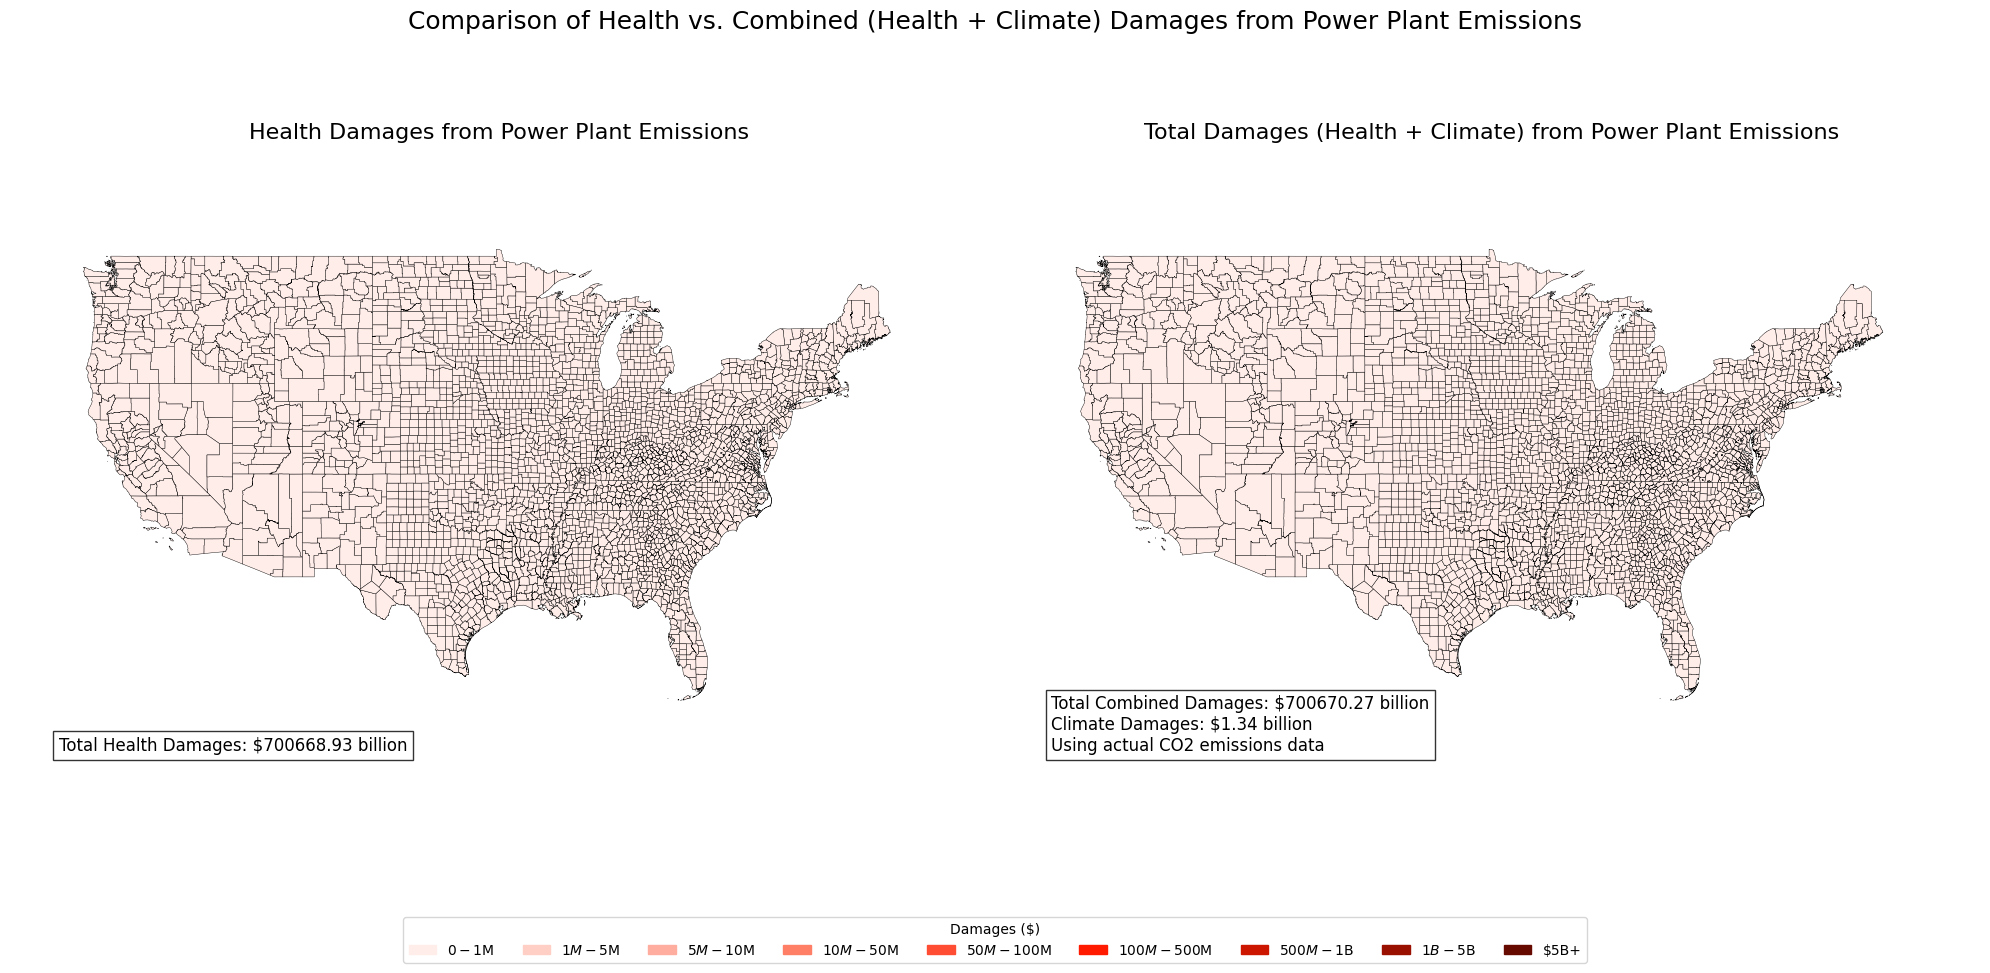

Visualization complete!


In [7]:
# ================================
# Step 2: Prepare county-level data for visualization
# ================================

# Load county boundaries
print("Loading county boundaries...")
us_counties = gpd.read_file("../data/raw/cb_2018_us_county_500k/cb_2018_us_county_500k.shp")

# Convert counties to match emissions data CRS
us_counties = us_counties.to_crs(resultsISRM.crs)

# Perform spatial join to assign each grid cell to a county
print("Joining health impacts to counties...")
results_county = resultsISRM.sjoin(us_counties, how="left", predicate="intersects")

# Aggregate health impacts by county
county_summary = results_county.groupby("NAME").agg({
    "SOA": "sum",
    "pNO3": "sum",
    "pNH4": "sum",
    "pSO4": "sum",
    "PrimaryPM25": "sum",
    "TotalPM25": "sum",
    "deathsK": "sum",
    "deathsL": "sum"
}).reset_index()

# Merge summary with county shapefile for visualization
us_counties = us_counties.merge(county_summary, on="NAME", how="left")

# Exclude Alaska, Hawaii, and Puerto Rico
us_counties = us_counties[~us_counties['STATEFP'].isin(["02", "15", "72"])]

# ================================
# Step 3: Calculate health damages
# ================================

# Value of a Statistical Life in dollars
VSL = 13.2e6  # $13.2 million per life

# Calculate health damages for each county
us_counties['HealthDamages'] = us_counties['deathsK'] * VSL

# Handle NaN values
us_counties.loc[:, 'HealthDamages'] = us_counties['HealthDamages'].fillna(0)

# ================================
# Step 4: Calculate climate damages using actual CO2 emissions
# ================================

# Join the CO2 emissions to counties for climate damage calculation
print("Calculating climate damages from CO2 emissions...")

# Spatial join to assign CO2 emissions to counties
egu_with_co2 = egu_with_co2.to_crs(us_counties.crs)
co2_county = egu_with_co2.sjoin(us_counties[['GEOID', 'geometry']], how="inner", predicate="within")

# Aggregate CO2 emissions by county
co2_summary = co2_county.groupby('GEOID')['CO2'].sum().reset_index()

# Social Cost of Carbon (SCC) in dollars per ton
SCC = 51  # $51 per ton of CO2 (based on EPA estimates)

# Calculate climate damages for each county
co2_summary['ClimateDamages'] = co2_summary['CO2'] * SCC

# Merge climate damages with county data
us_counties = us_counties.merge(co2_summary[['GEOID', 'ClimateDamages']], on='GEOID', how='left')
us_counties['ClimateDamages'] = us_counties['ClimateDamages'].fillna(0)

# Calculate total damages (health + climate)
us_counties['TotalDamages'] = us_counties['HealthDamages'] + us_counties['ClimateDamages']

# ================================
# Step 5: Create dual-panel visualization
# ================================

# Define bins and colors for damages
bins = [0, 1e6, 5e6, 10e6, 50e6, 100e6, 500e6, 1e9, 5e9, float("inf")]
colors = ['#ffedea', '#ffcec5', '#ffad9f', '#ff7f66', '#ff4d33', 
          '#ff1a00', '#cc1600', '#990f00', '#660a00']

# Create a discrete colormap
cmap = mcolors.ListedColormap(colors)

# Bin the health and total damages data
us_counties['HealthDamages_Binned'] = pd.cut(us_counties['HealthDamages'], bins=bins, labels=False, include_lowest=True)
us_counties['TotalDamages_Binned'] = pd.cut(us_counties['TotalDamages'], bins=bins, labels=False, include_lowest=True)

# Create figure with two panels
fig = plt.figure(figsize=(20, 10))
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 1])

# Left panel - Health Damages
ax1 = plt.subplot(gs[0])
us_counties.plot(column='HealthDamages_Binned', cmap=cmap, linewidth=0.3, edgecolor="black", 
                 ax=ax1, legend=False)
ax1.set_title('Health Damages from Power Plant Emissions', fontsize=16)
ax1.axis('off')
ax1.set_aspect(1.3)
ax1.set_xlim(-130, -60)
ax1.set_ylim(20, 55)

# Calculate total damages across all counties
total_health = us_counties['HealthDamages'].sum() / 1e9  # billions of dollars
total_climate = us_counties['ClimateDamages'].sum() / 1e9  # billions of dollars
total_combined = us_counties['TotalDamages'].sum() / 1e9  # billions of dollars

# Add text annotation with total health damages
ax1.text(0.05, 0.05, f'Total Health Damages: ${total_health:.2f} billion', 
         transform=ax1.transAxes, fontsize=12, bbox=dict(facecolor='white', alpha=0.8))

# Right panel - Total Damages (Health + Climate)
ax2 = plt.subplot(gs[1])
us_counties.plot(column='TotalDamages_Binned', cmap=cmap, linewidth=0.3, edgecolor="black", 
                 ax=ax2, legend=False)
ax2.set_title('Total Damages (Health + Climate) from Power Plant Emissions', fontsize=16)
ax2.axis('off')
ax2.set_aspect(1.3)
ax2.set_xlim(-130, -60)
ax2.set_ylim(20, 55)

# Add text annotation with total combined damages
ax2.text(0.05, 0.05, 
         f'Total Combined Damages: ${total_combined:.2f} billion\n' +
         f'Climate Damages: ${total_climate:.2f} billion\n' + 
         f'Using actual CO2 emissions data', 
         transform=ax2.transAxes, fontsize=12, bbox=dict(facecolor='white', alpha=0.8))

# Create formatted legend labels
legend_labels = [
    '$0 - $1M', 
    '$1M - $5M', 
    '$5M - $10M', 
    '$10M - $50M', 
    '$50M - $100M', 
    '$100M - $500M', 
    '$500M - $1B', 
    '$1B - $5B', 
    '$5B+'
]

# Create custom legend patches
legend_patches = [
    mpatches.Patch(color=colors[i], label=legend_labels[i]) 
    for i in range(len(legend_labels))
]

# Add the custom legend to the figure
fig.legend(handles=legend_patches, title="Damages ($)", 
           loc="lower center", ncol=len(legend_labels), bbox_to_anchor=(0.5, 0.02))

# Adjust layout
plt.tight_layout(rect=[0, 0.07, 1, 0.98])
plt.suptitle('Comparison of Health vs. Combined (Health + Climate) Damages from Power Plant Emissions', fontsize=18, y=0.98)

# Create output directory if it doesn't exist
output_dir = Path("../figures")
output_dir.mkdir(parents=True, exist_ok=True)

# Save the figure
plt.savefig("../figures/health_climate_damages_comparison.png", dpi=300, bbox_inches='tight')

# Show the figure
plt.show()

print("Visualization complete!")